In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/bhawks/.conda/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2023-01-10 13:38:22.233675: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-10 13:38:22.345823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-10 13:38:22.345860: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tqdm import trange

# Load data, select ADC

In [3]:
wireplane = "U"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    #edp_mask = np.all(extract_edp_info(data)>min_edp, axis = 1)
    #nel_mask = np.all(extract_nel_info(data)<max_mels, axis = 1)
    #pd.DataFrame(np.all(extract_edp_info(data)>min_edp, axis = 1)).describe()
    #print(edp_mask)
    #print(nel_mask)
    #filter_mask = nel_mask #np.logical_and(edp_mask,nel_mask) 
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    filtered_peak = extract_peak_info(cln_filtered_data)[1]
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

In [4]:
#X = np.load("data/X_argoneut.npz")
#y = np.load("data/y_argoneut.npz")
#old_peak = np.load("peak_argoneut.npz")

#Load Training Data
path = "/home/sayala/hls4ml-tutorial/Neutrino_Detector/Dune_1DCNN/dunesnb/1dcnn/train/train/nu_cc/"
path2 = "/home/sayala/hls4ml-tutorial/Neutrino_Detector/Dune_1DCNN/dunesnb/1dcnn/train/train/nu_es/"
filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
clean_filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]
filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
clean_filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
combined_clean_data = np.concatenate([np.load(fname) for fname in filenames])

noise_path = "/home/sayala/hls4ml-tutorial/Neutrino_Detector/Dune_1DCNN/dunesnb/1dcnn/train/train/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and sig_name in f)]
#print(noise_filenames)
noise_clean_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and cln_name in f)]

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])
#print(combined_noise)
#combined_clean_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_clean_filenames])



# Train/Noise Data Preprocessing



In [5]:
from sklearn.utils import shuffle
print(combined_data.shape[0])
#Filter out tiny signals < ADC_MIN, but leave big signals to test on (incl > ADC_MAX)
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, False)
print(combined_data.shape[0])

#split train and test sets (~50k ea before filtering) 
combined_data, x_test_data, combined_clean_data, x_test_clean  = train_test_split(
    combined_data, combined_clean_data, test_size=0.5, shuffle=True
)
print(combined_data.shape[0])
#filter data and extract waveforms of filtered data
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, True)
signal_waveforms = get_std_waveforms(combined_data)
print(combined_data.shape[0])
#extract waveforms of noise
noise_waveforms = get_std_waveforms(combined_noise)

#extract waveforms of test data
test_signal_waveforms = get_std_waveforms(x_test_data)
print(test_signal_waveforms.shape[0])
#generate y data (assuming all radiologicals contain signal, all noise does not)
y_noise_full = np.zeros(noise_waveforms.shape[0])
y_signal = np.ones(signal_waveforms.shape[0])
y_test_signal = np.ones(test_signal_waveforms.shape[0])


# split test and train noise datasets (50k)
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(
    noise_waveforms, y_noise_full, test_size=0.5, shuffle=True
)

#Shuffle signal waveforms to be safe
signal_waveforms, y_signal = shuffle(signal_waveforms,y_signal)

#Shuffle test waveformst to be safe
x_test, y_test = shuffle(test_signal_waveforms,y_test_signal)

#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set 
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train = np.concatenate((y_signal[:int(x_noise_train.shape[0])], y_noise_train))

x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test = np.concatenate((y_test_signal[:int(x_noise_test.shape[0])], y_noise_test))


# extra train shuffle for good measure 
x_train, y_train = shuffle(x_train,y_train)

# extra test shuffle for good measure 
x_test, y_test = shuffle(x_test,y_test)

#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

203316
112385
56192
53901
56193


# Load Test Data

In [6]:
'''
#Load Test Data
cc_path = "/home/sayala/hls4ml-tutorial/Neutrino_Detector/Dune_1DCNN/dunesnb/1dcnn/train/train/nu_cc/"
cc_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and sig_name in f)]
cc_clean_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and cln_name in f)]

es_path = "/home/sayala/hls4ml-tutorial/Neutrino_Detector/Dune_1DCNN/dunesnb/1dcnn/train/train/nu_es/"
es_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and sig_name in f)]
es_clean_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and cln_name in f)]

cc_combined_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])
es_combined_data = np.concatenate([np.load(es_path+fname) for fname in es_filenames])

cc_combined_clean_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])
es_combined_clean_data= np.concatenate([np.load(es_path+fname) for fname in es_filenames])
'''

'\n#Load Test Data\ncc_path = "/home/sayala/hls4ml-tutorial/Neutrino_Detector/Dune_1DCNN/dunesnb/1dcnn/train/train/nu_cc/"\ncc_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and sig_name in f)]\ncc_clean_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and cln_name in f)]\n\nes_path = "/home/sayala/hls4ml-tutorial/Neutrino_Detector/Dune_1DCNN/dunesnb/1dcnn/train/train/nu_es/"\nes_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and sig_name in f)]\nes_clean_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and cln_name in f)]\n\ncc_combined_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])\nes_combined_data = np.concatenate([np.load(es_path+fname) for fname in es_filenames])\n\ncc_combined_clean_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])\nes_combined_clean_data= np.concatenate([np.load(es_path+fname) for fname in es_filenames])\n'

# Test Data Pre-Processing

In [7]:
'''
cc_combined_data, cc_combined_clean_data, cc_peak = filter_signals(cc_combined_data, cc_combined_clean_data)
es_combined_data, es_combined_clean_data, es_peak = filter_signals(es_combined_data, es_combined_clean_data)

cc_signal_waveforms = get_std_waveforms(cc_combined_data)
es_signal_waveforms = get_std_waveforms(es_combined_data)

cc_y_signal = np.ones(cc_signal_waveforms.shape[0])
es_y_signal = np.ones(es_signal_waveforms.shape[0])

#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test 
cc_x_test = np.concatenate((cc_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))
cc_y_test = np.concatenate((cc_y_signal[:int(x_noise_test.shape[0])], y_noise_test))

#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test 
es_x_test = np.concatenate((es_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))
es_y_test = np.concatenate((es_y_signal[:int(x_noise_test.shape[0])], y_noise_test))

#shuffle for good measure 
from sklearn.utils import shuffle
cc_x_test, cc_y_test = shuffle(cc_x_test,cc_y_test)
es_x_test, es_y_test = shuffle(es_x_test,es_y_test)
'''

'\ncc_combined_data, cc_combined_clean_data, cc_peak = filter_signals(cc_combined_data, cc_combined_clean_data)\nes_combined_data, es_combined_clean_data, es_peak = filter_signals(es_combined_data, es_combined_clean_data)\n\ncc_signal_waveforms = get_std_waveforms(cc_combined_data)\nes_signal_waveforms = get_std_waveforms(es_combined_data)\n\ncc_y_signal = np.ones(cc_signal_waveforms.shape[0])\nes_y_signal = np.ones(es_signal_waveforms.shape[0])\n\n#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test \ncc_x_test = np.concatenate((cc_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))\ncc_y_test = np.concatenate((cc_y_signal[:int(x_noise_test.shape[0])], y_noise_test))\n\n#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test \nes_x_test = np.concatenate((es_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))\nes_y_test = np.concatenate((es_y_signal[:int(x_noise_test.s

In [8]:
#pd.DataFrame(extract_nel_info(combined_data)).describe()

In [9]:
#pd.DataFrame(old_peak["training_set"]).describe()


In [10]:
#for i in range(0,5): 
#    plt.hist(peak[:,i],bins=120)
#    plt.show()
#pd.DataFrame(peak).describe()

In [11]:
#for i in range(0,5): 
#    plt.hist(unscaled_peak[:,i],bins=120)
#    plt.show()
#pd.DataFrame(unscaled_peak).describe()

In [12]:
#x_train = X["training_set"]
#y_train = y["training_set"]#
#x_test = X["test_set"]
#y_test = y["test_set"]

#peak_train = peak["training_set"]
#peak_test = peak["test_set"]
#del y
#del X
#del peak

In [13]:
#ADC_MIN = 3

In [14]:
#signal = x_train[y_train == 1]
#noise = x_train[y_train == 0]

#peak_signal = peak_train[y_train == 1]
#peak_noise =  peak_train[y_train == 0]

In [15]:
#signal_test = x_test[y_test == 1]
#noise_test = x_test[y_test == 0]

#peak_signal_test = peak_test[y_test == 1]
#peak_noise_test =  peak_test[y_test == 0]

In [16]:
#mask = np.any(peak_signal>ADC_MIN, axis = 1)
#peak_signal = signal[mask]
#signal = signal[mask]

In [17]:
#mask = np.any(peak_signal_test>ADC_MIN, axis = 1)
#peak_signal_test = signal_test[mask]
#signal_test = signal_test[mask]

In [18]:
#y_noise = np.zeros(signal.shape[0])
#y_signal = np.ones(signal.shape[0])

#x_train = np.concatenate((noise[:signal.shape[0]], signal))
#y_train = np.concatenate((y_noise, y_signal))
#from sklearn.utils import shuffle
#x_train, y_train = shuffle(x_train,y_train)

In [19]:
#y_noise_test = np.zeros(signal_test.shape[0])
#y_signal_test = np.ones(signal_test.shape[0])

#x_test = np.concatenate((noise_test[:signal_test.shape[0]], signal_test))
#y_test = np.concatenate((y_noise_test, y_signal_test))
#from sklearn.utils import shuffle
#x_test, y_test = shuffle(x_test,y_test)

In [20]:
x_train.shape

(86560, 200)

In [21]:
x_valid.shape

(21641, 200)

In [22]:
mean = x_train.mean()
std = x_train.std()

In [23]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std
#cc_x_test_scaled = (cc_x_test-mean)/std 
#es_x_test_scaled = (es_x_test-mean)/std 
time_periods = 200

In [24]:
np.save("models/mean_u_nu", mean)
np.save("models/scale_u_nu", std)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

In [26]:
time_periods = 200
def create_model():
  model = Sequential()  
  #first convolutional block
  model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
  model.add(MaxPooling1D(pool_size=2))

  #second convolutional block
  model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.1))
  
  #forth convolutional block
  model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2)) 
    
  model.add(Flatten())

  
 
  model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
  return model


model = create_model()

#lr=0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             1

2023-01-10 13:38:35.397525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-10 13:38:35.397788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-10 13:38:35.397979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-10 13:38:35.398091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-10 13:38:35.398190: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [27]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
#cc_x_test_scaled = cc_x_test_scaled.reshape(cc_x_test_scaled.shape[0], cc_x_test_scaled.shape[1], 1)
#es_x_test_scaled = es_x_test_scaled.reshape(es_x_test_scaled.shape[0], es_x_test_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)
print(x_train_scaled.shape[0])
print(x_valid_scaled.shape[0])
print(x_test_scaled.shape[0])

86560
21641
108600


In [28]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [29]:
%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

Epoch 1/100
43/43 [==============================] - 3s 50ms/step - loss: 0.5373 - accuracy: 0.6768 - val_loss: 0.3716 - val_accuracy: 0.8626
Epoch 2/100
43/43 [==============================] - 2s 42ms/step - loss: 0.3049 - accuracy: 0.8790 - val_loss: 0.2640 - val_accuracy: 0.8969
Epoch 3/100
43/43 [==============================] - 2s 43ms/step - loss: 0.2614 - accuracy: 0.8963 - val_loss: 0.2499 - val_accuracy: 0.9031
Epoch 4/100
43/43 [==============================] - 2s 41ms/step - loss: 0.2499 - accuracy: 0.9031 - val_loss: 0.2434 - val_accuracy: 0.9055
Epoch 5/100
43/43 [==============================] - 2s 42ms/step - loss: 0.2448 - accuracy: 0.9056 - val_loss: 0.2407 - val_accuracy: 0.9067
Epoch 6/100
43/43 [==============================] - 2s 42ms/step - loss: 0.2421 - accuracy: 0.9075 - val_loss: 0.2388 - val_accuracy: 0.9073
Epoch 7/100
43/43 [==============================] - 2s 41ms/step - loss: 0.2401 - accuracy: 0.9089 - val_loss: 0.2379 - val_accuracy: 0.9076
Epoch 

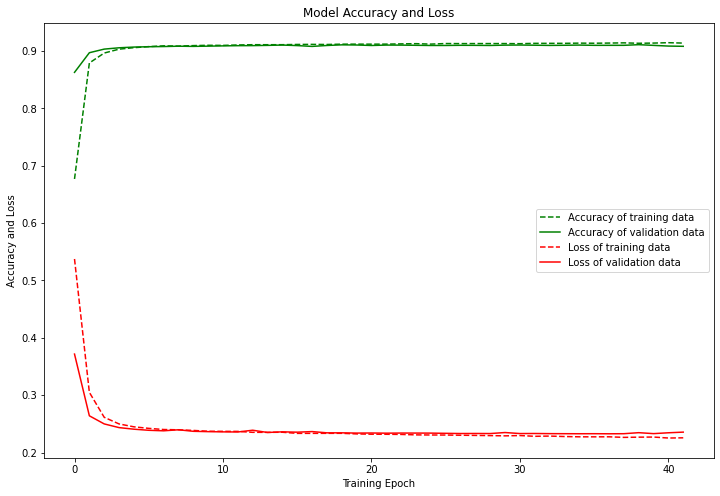

In [30]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [31]:
#del x_train

import gc
gc.collect()

5379

In [32]:
model.save("models/uplane_nu.h5")

In [33]:
history.history['loss']

[0.5373480319976807,
 0.3048986792564392,
 0.2614183723926544,
 0.24985170364379883,
 0.24481943249702454,
 0.24212129414081573,
 0.24013398587703705,
 0.23961642384529114,
 0.23852406442165375,
 0.23709924519062042,
 0.23691368103027344,
 0.2368193417787552,
 0.23523128032684326,
 0.23516800999641418,
 0.23535041511058807,
 0.2334069013595581,
 0.23343385756015778,
 0.2334534078836441,
 0.233488529920578,
 0.23246391117572784,
 0.23193547129631042,
 0.23181693255901337,
 0.23154696822166443,
 0.230775386095047,
 0.2305726408958435,
 0.23049212992191315,
 0.23016177117824554,
 0.22984462976455688,
 0.22951306402683258,
 0.22906938195228577,
 0.22960753738880157,
 0.22827884554862976,
 0.22867709398269653,
 0.22789056599140167,
 0.2274082601070404,
 0.2273576259613037,
 0.2274213433265686,
 0.22641810774803162,
 0.2267833799123764,
 0.22699414193630219,
 0.2252737432718277,
 0.2256585955619812]

In [34]:
history.history['val_loss']

[0.37160539627075195,
 0.26402774453163147,
 0.2498844712972641,
 0.2434464544057846,
 0.24067595601081848,
 0.2387789785861969,
 0.2378585785627365,
 0.2396683692932129,
 0.23699580132961273,
 0.23641690611839294,
 0.23602059483528137,
 0.23580637574195862,
 0.23888519406318665,
 0.2349497675895691,
 0.23607081174850464,
 0.2354753464460373,
 0.23651878535747528,
 0.23433950543403625,
 0.2343439757823944,
 0.233905628323555,
 0.23404821753501892,
 0.23374097049236298,
 0.2339472472667694,
 0.23390869796276093,
 0.23385143280029297,
 0.23348282277584076,
 0.2331339567899704,
 0.23322883248329163,
 0.23309428989887238,
 0.23485630750656128,
 0.2330797165632248,
 0.23318521678447723,
 0.2329433411359787,
 0.23284056782722473,
 0.232753187417984,
 0.23282410204410553,
 0.23266729712486267,
 0.2328297644853592,
 0.23460796475410461,
 0.23294979333877563,
 0.23443108797073364,
 0.235564187169075]

In [35]:
history.history['accuracy']

[0.6768137812614441,
 0.8789741396903992,
 0.896303117275238,
 0.9030614495277405,
 0.9056492447853088,
 0.9074861407279968,
 0.9088609218597412,
 0.9083872437477112,
 0.909253716468811,
 0.9098082184791565,
 0.909623384475708,
 0.9103627800941467,
 0.9108595252037048,
 0.9108248353004456,
 0.9108595252037048,
 0.9112753868103027,
 0.9114025235176086,
 0.9112176299095154,
 0.9117606282234192,
 0.9118068218231201,
 0.9117721915245056,
 0.9118415117263794,
 0.9122804999351501,
 0.9126501679420471,
 0.9118761420249939,
 0.9128696918487549,
 0.9127426147460938,
 0.912823498249054,
 0.9128119349479675,
 0.912823498249054,
 0.9126039743423462,
 0.9132047295570374,
 0.9132162928581238,
 0.9132162928581238,
 0.9135743975639343,
 0.9134011268615723,
 0.9136783480644226,
 0.9140596389770508,
 0.9133318066596985,
 0.913666844367981,
 0.9143484234809875,
 0.9136437177658081]

In [36]:
history.history['val_accuracy']

[0.8626219034194946,
 0.8968624472618103,
 0.9031468033790588,
 0.9054572582244873,
 0.906704843044281,
 0.9073055982589722,
 0.9076290130615234,
 0.9082297682762146,
 0.9079062938690186,
 0.9083221554756165,
 0.9087842702865601,
 0.909153938293457,
 0.9092463254928589,
 0.9096621870994568,
 0.9102166891098022,
 0.9092925190925598,
 0.9078601002693176,
 0.9094773530960083,
 0.910586416721344,
 0.9103091359138489,
 0.9094773530960083,
 0.9101704955101013,
 0.9101243019104004,
 0.9098008275032043,
 0.9094773530960083,
 0.909523606300354,
 0.9098008275032043,
 0.9097084403038025,
 0.909523606300354,
 0.9100781083106995,
 0.910262942314148,
 0.9099394679069519,
 0.9096159934997559,
 0.9098470211029053,
 0.9101704955101013,
 0.9097546339035034,
 0.9097546339035034,
 0.9097546339035034,
 0.9108636379241943,
 0.9096621870994568,
 0.908460795879364,
 0.9080449342727661]

In [37]:
model.evaluate(x_test_scaled, y_test, batch_size=4096)

27/27 [==============================] - 1s 22ms/step - loss: 0.2218 - accuracy: 0.9167


[0.22175399959087372, 0.9166574478149414]

In [38]:
#model.evaluate(es_x_test_scaled, es_y_test, batch_size=4096)

In [39]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


# Train

In [40]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=4096)

22/22 [==============================] - 1s 32ms/step
CPU times: user 5.75 s, sys: 786 ms, total: 6.54 s
Wall time: 1.03 s


<AxesSubplot:>

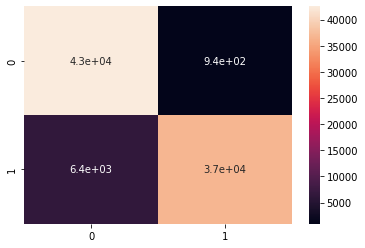

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_, infer>0.5)
sns.heatmap(cm, annot=True)

<AxesSubplot:>

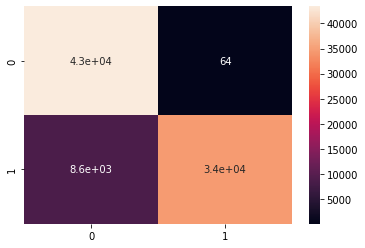

In [42]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_train_, infer>0.9)
sns.heatmap(cm2, annot=True)

In [43]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)

In [44]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [45]:
np.save("results/false_positive_V_train", fpr_keras)
np.save("results/true_positive_V_train", tpr_keras)
np.save("results/thresholds_V_train", thresholds_keras)

In [46]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

# Valid

In [47]:
%%time
infer = model.predict(x_valid_, batch_size=4096)

6/6 [==============================] - 0s 25ms/step
CPU times: user 1.15 s, sys: 123 ms, total: 1.27 s
Wall time: 214 ms


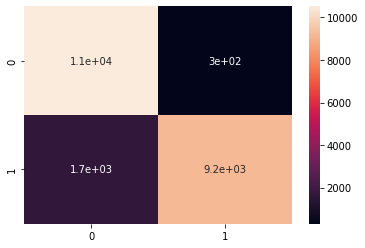

In [48]:
from sklearn.metrics import confusion_matrix
cmv = confusion_matrix(y_valid_, infer>0.5)
sns.heatmap(cmv, annot=True)
plt.show()

<AxesSubplot:>

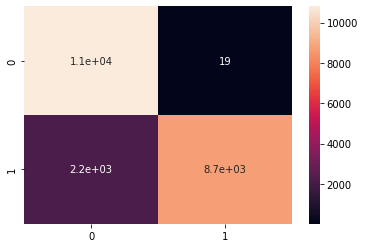

In [49]:
from sklearn.metrics import confusion_matrix
cmv2 = confusion_matrix(y_valid_, infer>0.9)
sns.heatmap(cmv2, annot=True)

In [50]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid_, infer)

In [51]:
np.save("results/false_positive_V_valid", fpr_keras)
np.save("results/true_positive_V_valid", tpr_keras)
np.save("results/thresholds_V_valid", thresholds_keras)

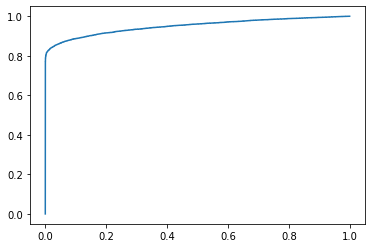

In [52]:
plt.plot(fpr_keras, tpr_keras)

# test

In [53]:
#%%time
#cc_infer = model.predict(cc_x_test_scaled, batch_size=4096)
#es_infer = model.predict(es_x_test_scaled, batch_size=4096)
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


27/27 [==============================] - 1s 22ms/step


In [54]:
from sklearn.metrics import confusion_matrix
#cc1 = confusion_matrix(cc_y_test, cc_infer>0.5)
#sns.heatmap(cc1, annot=True)

In [55]:
#es1 = confusion_matrix(es_y_test, es_infer>0.5)
#sns.heatmap(es1, annot=True)

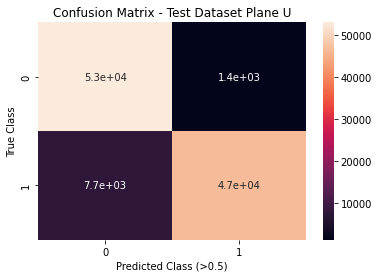

In [56]:
all1 = confusion_matrix(all_y_test, all_infer>0.5)
sns.heatmap(all1, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

In [57]:
from sklearn.metrics import confusion_matrix
#cc2 = confusion_matrix(cc_y_test, cc_infer>0.9)
#sns.heatmap(cc2, annot=True)

In [58]:
#es2 = confusion_matrix(es_y_test, es_infer>0.9)
#sns.heatmap(es2, annot=True)

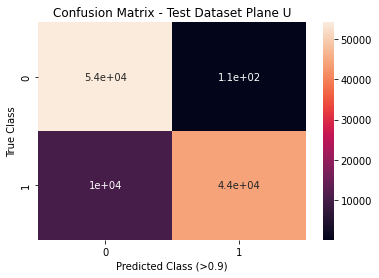

In [59]:
all2 = confusion_matrix(all_y_test, all_infer>0.9)
sns.heatmap(all2, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.9)")
plt.ylabel("True Class")
plt.show()

In [60]:
from sklearn.metrics import roc_curve
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(cc_y_test, cc_infer)
#plt.plot(fpr_keras, tpr_keras)

In [61]:
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(es_y_test, es_infer)
#plt.plot(fpr_keras, tpr_keras)

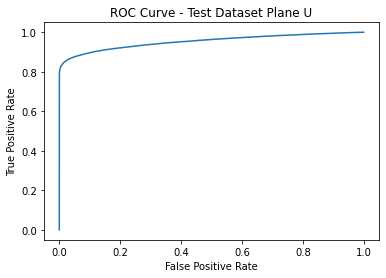

In [62]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras)
plt.title("ROC Curve - Test Dataset Plane " + wireplane)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [63]:
np.save("results/false_positive_V_test", fpr_keras)
np.save("results/true_positive_V_test", tpr_keras)
np.save("results/thresholds_V_test", thresholds_keras)

In [64]:
#plt.hist(cc_infer, bins = 100);

In [65]:
#plt.hist(es_infer, bins = 100);

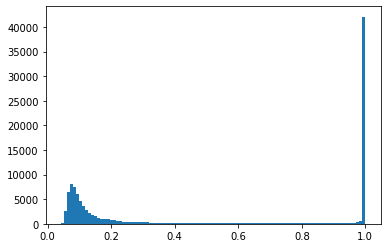

In [66]:
plt.hist(all_infer, bins = 100);

In [67]:
%%time
#cc_infer_signal = model.predict(cc_x_test_scaled[cc_y_test==1], batch_size=4096)
#cc_infer_noise = model.predict(cc_x_test_scaled[cc_y_test==0], batch_size=4096)
#es_infer_signal = model.predict(es_x_test_scaled[es_y_test==1], batch_size=4096)
#es_infer_noise = model.predict(es_x_test_scaled[es_y_test==0], batch_size=4096)
all_infer_signal = model.predict(x_test_scaled[y_test==1], batch_size=4096)
all_infer_noise = model.predict(x_test_scaled[y_test==0], batch_size=4096)

14/14 [==============================] - 0s 21ms/step
CPU times: user 4.53 s, sys: 580 ms, total: 5.11 s
Wall time: 837 ms


In [68]:
#plt.hist(cc_infer_noise, range = (0,1), bins=20)

In [69]:
#plt.hist(es_infer_noise, range = (0,1), bins=20)

(array([  156., 29125., 13103.,  4632.,  2237.,  1338.,   927.,   576.,
          492.,   341.,   253.,   234.,   194.,   147.,   127.,   134.,
           86.,    84.,    73.,    41.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

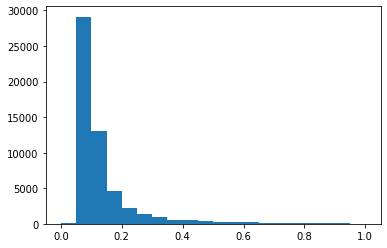

In [70]:
plt.hist(all_infer_noise, range = (0,1), bins=20)

In [71]:
#plt.hist(cc_infer_signal, range = (0,1), bins=20)

In [72]:
#plt.hist(es_infer_signal, range = (0,1), bins=20)

(array([6.0000e+00, 2.2270e+03, 1.8650e+03, 9.6300e+02, 7.0800e+02,
        5.3500e+02, 4.0700e+02, 3.3900e+02, 3.2100e+02, 3.0700e+02,
        2.8300e+02, 2.4200e+02, 3.1400e+02, 2.5100e+02, 3.0600e+02,
        2.9800e+02, 3.4200e+02, 4.7000e+02, 7.1200e+02, 4.3404e+04]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

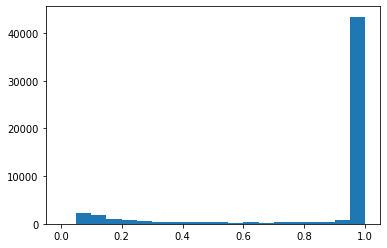

In [73]:
plt.hist(all_infer_signal, range = (0,1), bins=20)

## HLS4ML 


In [74]:
import hls4ml

/home/sayala/miniconda3/envs/hls4ml-tutorial/lib/python3.8/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [75]:
load_model = tf.keras.models.load_model('models/uplane_nu.h5')

In [76]:
# config = hls4ml.utils.config_from_keras_model(load_model, granularity='name')
# config['IOType'] = 'io_stream'
# print(config)

In [77]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             1

In [78]:
# cfg = hls4ml.converters.create_config(backend='Vivado')
# cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
# cfg['HLSConfig']  = config
# cfg['KerasModel'] = load_model
# # cfg['OutputDir']  = 'model1/'
# cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'

In [79]:
from qkeras.utils import _add_supported_quantized_objects

co= {}
_add_supported_quantized_objects(co)

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config["Model"]["Strategy"] = 'Resource'
#config["LayerName"]['Conv_1_input']['Precision'] = 'ap_uint<32>'
for layer in config["LayerName"]:
    config["LayerName"][layer]['ReuseFactor'] = 16
    config["LayerName"][layer]["ConvImplementation"] = "encoded"
    
print(config)

Interpreting Sequential
Topology:
Layer name: conv1d_input, layer type: Input
Layer name: conv1d, layer type: Conv1D
  -> Activation (relu), layer name: conv1d
Layer name: max_pooling1d, layer type: MaxPooling1D
Layer name: conv1d_1, layer type: Conv1D
  -> Activation (relu), layer name: conv1d_1
Layer name: max_pooling1d_1, layer type: MaxPooling1D
Layer name: conv1d_2, layer type: Conv1D
  -> Activation (relu), layer name: conv1d_2
Layer name: global_max_pooling1d, layer type: GlobalMaxPooling1D
Layer name: wavrec_out, layer type: Dense
  -> Activation (sigmoid), layer name: wavrec_out
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Resource'}, 'LayerName': {'conv1d_input': {'Precision': {'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 48, 'ConvImplementation': 'encoded'}, 'conv1d': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 48, 'ConvImplementation': 'encoded'}, 'conv1d_relu': {'Precision': 'ap

In [80]:
# # hls_model = hls4ml.converters.keras_to_hls(cfg)
# hls_model = hls4ml.converters.keras_to_hls(cfg)


In [81]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       io_type='io_stream',
                                                       output_dir='uplane-test',
                                                       part='xc7vx690t-ffg1761-2',
                                                       clock_period=3.33,
                                                       #project_name='vplane'
                                                      )

Interpreting Sequential
Topology:
Layer name: conv1d_input, layer type: InputLayer, input shapes: [[None, 200, 1]], output shape: [None, 200, 1]
Layer name: conv1d, layer type: Conv1D, input shapes: [[None, 200, 1]], output shape: [None, 99, 16]
Layer name: max_pooling1d, layer type: MaxPooling1D, input shapes: [[None, 99, 16]], output shape: [None, 49, 16]
Layer name: conv1d_1, layer type: Conv1D, input shapes: [[None, 49, 16]], output shape: [None, 23, 32]
Layer name: max_pooling1d_1, layer type: MaxPooling1D, input shapes: [[None, 23, 32]], output shape: [None, 11, 32]
Layer name: conv1d_2, layer type: Conv1D, input shapes: [[None, 11, 32]], output shape: [None, 3, 64]
Layer name: global_max_pooling1d, layer type: GlobalMaxPooling1D, input shapes: [[None, 3, 64]], output shape: [None, 64]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: wavrec_out, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 1]
Creatin

In [82]:
hls_model.compile()
model.summary()

Writing HLS project
Done
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (N

In [83]:
#Use Vivado HLS to synthesize the model
#This might take several minutes
hls_model.build(csim=False)



****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'sayala' on host 'Steph_Laptop.localdomain' (Linux_x86_64 version 5.10.16.3-microsoft-standard-WSL2) on Tue Jan 10 13:40:07 PST 2023
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/sayala/hls4ml-tutorial/Neutrino_Detector/Dune_1DCNN/lartpc-dune-1dcnn-main/LArTPC_Training_Notebooks/Neutrino_Trained/uplane-test'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/sayala/hls4ml-tutorial/Neutrino_Detector/Dune_1DCNN/lartpc-dune-1dcnn-main/LArTPC_Training_Notebooks/Neutrino_Tr

INFO: [XFORM 203-603] Inlining function 'nnet::scale_index_K_gte_S<3u, 2u, 200u>' into 'nnet::scale_index<3u, 2u, 200u>' (firmware/nnet_utils/nnet_conv_stream.h:65).
INFO: [XFORM 203-603] Inlining function 'nnet::scale_index<3u, 2u, 200u>' into 'nnet::compute_scaled_indices_1d<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config2>' (firmware/nnet_utils/nnet_conv1d_stream.h:20).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>::operator[].1' into 'nnet::compute_output_encoded<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>' (firmware/nnet_utils/nnet_conv_stream.h:139).
INFO: [XFORM 203-603] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> >::product' into 'nnet::dense_resource_rf_gt_nin_rem0<

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>::operator[]' into 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, sigmoid_config13>' (firmware/nnet_utils/nnet_activation_stream.h:109).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>::operator[]' into 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, sigmoid_config13>' (firmware/nnet_utils/nnet_activation_stream.h:105).
INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:55 ; elapsed = 00:00:58 . Memory (MB): peak = 958.340 ; gain = 525.137 ; free physical = 9924 ; free virtual = 16068
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'nnet::compute_scaled_indices_1d<nnet::array<

INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReLUActLoop' (firmware/nnet_utils/nnet_activation_stream.h:60) in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, relu_config9>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReLUActLoop' (firmware/nnet_utils/nnet_activation_stream.h:60) in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, relu_config6>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReLUActLoop' (firmware/nnet_utils/nnet_activation_stream.h:60) in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, relu_config3>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReadInputWidth

INFO: [HLS 200-489] Unrolling loop 'CastLoop' (firmware/nnet_utils/nnet_conv_stream.h:99) in function 'nnet::conv_1d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, config8>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'CopyDataFilt' (firmware/nnet_utils/nnet_conv_stream.h:135) in function 'nnet::conv_1d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'InitData' (firmware/nnet_utils/nnet_conv_stream.h:87) in function 'nnet::conv_1d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'InitAccum' (firmware/nnet_utils/nnet_dense_resource.h:130) in function 'nnet::con

INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.9' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data.V' (firmware/nnet_utils/nnet_conv_stream.h:82) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'res.i.i.i'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b8.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:54) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'config2::pixels.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'pixel_idx.V' (firmware/nnet_utils/nnet_conv1d_stream.h:46) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data.V' (firmware/nnet_utils/nnet_conv_stream.h:82) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'res.i.i.i'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b2.V'  in dimension 1 completely.
INFO: [XFORM 203-101]

INFO: [XFORM 203-602] Inlining function 'nnet::compute_scaled_indices_1d<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' into 'nnet::conv_1d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>' (firmware/nnet_utils/nnet_conv1d_stream.h:54->firmware/nnet_utils/nnet_conv1d_stream.h:90) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5_mult>' into 'nnet::conv_1d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>' (firmware/nnet_utils/nnet_dense_resource.h:99->firmware/nnet_utils/nnet_dense_resource.h:274->firmware/nnet_utils/nnet_conv_stream.h:96->firmware/nnet_utils/nnet_conv_stream.h:143->firmware/nnet_utils/nnet_conv1d_stream.h:55->firmware/nnet_utils/nnet_c

INFO: [XFORM 203-603] Inlining function 'aesl_mux_load.6i3P.i3' into 'nnet::conv_1d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>' (firmware/nnet_utils/nnet_conv1d_stream.h:21->firmware/nnet_utils/nnet_conv1d_stream.h:54->firmware/nnet_utils/nnet_conv1d_stream.h:90).
INFO: [XFORM 203-603] Inlining function 'aesl_mux_load.9i5P.i4' into 'nnet::conv_1d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>' (firmware/nnet_utils/nnet_conv1d_stream.h:21->firmware/nnet_utils/nnet_conv1d_stream.h:54->firmware/nnet_utils/nnet_conv1d_stream.h:90).
INFO: [XFORM 203-603] Inlining function 'aesl_mux_load.17i9P.i5' into 'nnet::conv_1d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, config8>' (firmware/nnet_utils/nnet_conv1d_stream

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Block_proc' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 500.48 seconds; current allocated memory: 527.526 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.08 seconds; current allocated memory: 527.572 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_1d_cl_array_array_ap_fixed_16u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------

INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 6.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.91 seconds; current allocated memory: 555.080 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.85 seconds; current allocated memory: 558.446 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_1d_cl_array_array_ap_fixed_64u_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 7.
	

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.17 seconds; current allocated memory: 611.860 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.44 seconds; current allocated memory: 613.630 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-archite

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_16_6_5_3_0_1u_config12_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_array_ap_fixed_16_6_5_3_0_1u_config12_s'.
INFO: [HLS 200-111]  Elapsed time: 2.13 seconds; current allocated memory: 890.698 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_array_array_ap_fixed_1u_sigmoid_config13_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'sigmoid_array_array_ap_fixed_1u_sigmoid_config13_s_sigmoid_table10' to 'sigmoid_array_array_ap_fixed_1u_sigmoid_config13_s_sigmoidEe' due to the length limit 60
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoi

INFO: [RTMG 210-285] Implementing FIFO 'data_window_10_V_V_U(fifo_w16_d23_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_11_V_V_U(fifo_w16_d23_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_12_V_V_U(fifo_w16_d23_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_13_V_V_U(fifo_w16_d23_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_14_V_V_U(fifo_w16_d23_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_15_V_V_U(fifo_w16_d23_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_16_V_V_U(fifo_w16_d23_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_17_V_V_U(fifo_w16_d23_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_18_V_V_U(fifo_w16_d23_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_19_V_V_U(fifo_w16_d23_A)' using Shift R

INFO: [RTMG 210-285] Implementing FIFO 'data_window_15_V_V_U(fifo_w16_d11_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_16_V_V_U(fifo_w16_d11_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_17_V_V_U(fifo_w16_d11_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_18_V_V_U(fifo_w16_d11_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_19_V_V_U(fifo_w16_d11_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_20_V_V_U(fifo_w16_d11_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_21_V_V_U(fifo_w16_d11_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_22_V_V_U(fifo_w16_d11_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_23_V_V_U(fifo_w16_d11_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_24_V_V_U(fifo_w16_d11_A)' using Shift R

INFO: [RTMG 210-285] Implementing FIFO 'data_window_35_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_36_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_37_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_38_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_39_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_40_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_41_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_42_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_43_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_44_V_V_U(fifo_w16_d3_A)' using Shift Registers.


INFO: [RTMG 210-285] Implementing FIFO 'data_window_120_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_121_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_122_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_123_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_124_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_125_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_126_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_127_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_128_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_129_V_V_U(fifo_w16_d3_A)' using Shift R

INFO: [RTMG 210-285] Implementing FIFO 'data_window_204_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_205_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_206_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_207_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_208_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_209_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_210_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_211_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_212_V_V_U(fifo_w16_d3_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'data_window_213_V_V_U(fifo_w16_d3_A)' using Shift R

INFO: [RTMG 210-279] Implementing memory 'dense_wrapper_ap_fixed_ap_fixed_16_6_5_3_0_config12_s_w12_V_rom' using distributed ROMs.
INFO: [RTMG 210-279] Implementing memory 'sigmoid_array_array_ap_fixed_1u_sigmoid_config13_s_sigmoidEe_rom' using auto ROMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_0_V_U(fifo_w16_d99_A_x)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_1_V_U(fifo_w16_d99_A_x)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_2_V_U(fifo_w16_d99_A_x)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_3_V_U(fifo_w16_d99_A_x)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_4_V_U(fifo_w16_d99_A_x)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_5_V_U(fifo_w16_d99_A_x)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_6_V_U(fifo_w16_d99_A_x)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIF

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_29_V_U(fifo_w16_d23_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_30_V_U(fifo_w16_d23_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_31_V_U(fifo_w16_d23_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_0_V_U(fifo_w16_d23_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_1_V_U(fifo_w16_d23_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_2_V_U(fifo_w16_d23_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_3_V_U(fifo_w16_d23_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_4_V_U(fifo_w16_d23_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_5_V_U(fifo_w16_d23_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'lay

INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_11_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_12_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_13_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_14_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_15_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_16_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_17_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_18_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_19_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8

INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_25_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_26_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_27_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_28_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_29_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_30_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_31_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_32_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_33_V_U(fifo_w16_d3_A_x)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9

{'EstimatedClockPeriod': '3.644',
 'BestLatency': '11328',
 'WorstLatency': '11429',
 'IntervalMin': '601',
 'IntervalMax': '11401',
 'BRAM_18K': '284',
 'DSP48E': '451',
 'FF': '60207',
 'LUT': '83853',
 'URAM': '0',
 'AvailableBRAM_18K': '2940',
 'AvailableDSP48E': '3600',
 'AvailableFF': '866400',
 'AvailableLUT': '433200',
 'AvailableURAM': '0'}

In [85]:
#Print out the report if you want
hls4ml.report.read_vivado_report('myproject')

Path myproject does not exist. Exiting.
